Imports & Setup

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

from xgboost import XGBRegressor

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

plt.style.use("seaborn-v0_8")



Load & Prepare Data

In [ ]:
df = pd.read_csv("/content/PJME_hourly.csv")

df['datetime'] = pd.to_datetime(df['Datetime'])
df = df.set_index('datetime').sort_index()

df = df[['PJME_MW']].rename(columns = {'PJME_MW' : 'load'})
df = df.groupby(df.index).mean()
df = df.asfreq('h')
df = df.interpolate(method='time')

df.head()

*   The Datetime column is converted to a proper datetime format and set as the index to ensure the data is treated as a time-indexed series, which is essential for time series analysis and forecasting.

*   Sorting the data by time guarantees that observations are in strict chronological order, preventing any unintended leakage of future information into past observations.

*   The data is then grouped by the datetime index and averaged to handle cases where multiple records exist for the same timestamp. This ensures a single, consistent electricity demand value per hour.

*   The time series is resampled to a strict hourly frequency using asfreq('h') to create a continuous and evenly spaced time index, which many forecasting models require.

*   Any missing hourly values introduced during resampling are filled using time-based interpolation, allowing the series to remain continuous while preserving the underlying temporal structure.





Exploratory Visualization

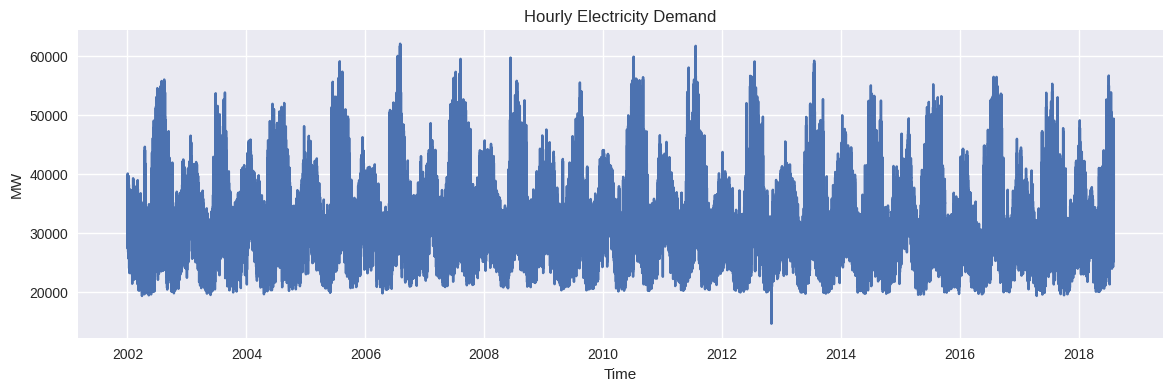

In [ ]:
plt.figure(figsize = (14,4))
plt.plot(df['load'])
plt.title("Hourly Electricity Demand")
plt.xlabel("Time")
plt.ylabel("MW")
plt.show()



*   The plot shows hourly electricity demand from **2002 to 2018**, giving an overview of how demand evolves over time.

*   Clear repeating patterns can be observed, reflecting daily and weekly electricity usage cycles.

*   Demand varies substantially, with regular peaks during high-usage periods and lower values during off-peak hours.

*   In some periods, demand rises above **60,000 MW**, highlighting the difficulty of forecasting extreme load conditions.

*   Both the average demand level and its variability change over time, indicating non-stationary behavior and motivating the use of advanced forecasting models.


Feature Engineering

In [ ]:
def create_features(df):
  df = df.copy()

  df['hour'] = df.index.hour
  df['dayofweek'] = df.index.dayofweek
  df['month'] = df.index.month
  df['is_weekend'] = (df['dayofweek'] >= 5).astype(int)

  for lag in [1, 24, 48, 168]:
    df[f'lag_{lag}'] = df['load'].shift(lag)

  df['rolling_mean_24'] = df['load'].shift(1).rolling(24).mean()
  df['rolling_std_24'] = df['load'].shift(1).rolling(24).std()

  return df.dropna()

df_feat = create_features(df)

*   This function transforms the original time series into a supervised learning format suitable for machine learning models.

*   Calendar-based features such as hour, day of week, month, and weekend indicators are created to capture recurring temporal patterns in electricity demand.

*   Lagged demand values at multiple horizons (1 hour, 24 hours, 48 hours, and 168 hours) are added to represent short-term, daily, and weekly dependencies.

*   Rolling statistics are computed to summarize recent demand behavior, providing contextual information about local trends and variability.

*   Rows containing missing values introduced by lagging and rolling operations are removed to ensure a clean training dataset.






Train-Test Split

In [ ]:
split_date = df_feat.index[int(len(df_feat) * 0.8)]

train = df_feat.loc[:split_date]
test  = df_feat.loc[split_date:]

x_train = train.drop('load', axis = 1)
y_train = train['load']

x_test = test.drop('load', axis = 1)
y_test = test['load']

Evaluation Function

In [ ]:
def evaluate(y_true, y_pred, model_name):
  mae = mean_absolute_error(y_true, y_pred)
  rmse = np.sqrt(mean_squared_error(y_true, y_pred))
  print(f"{model_name}")
  print(f"MAE : {mae:.2f}")
  print(f"RMSE: {rmse:.2f}\n")

*   This function evaluates model performance using **Mean Absolute Error (MAE)** and **Root Mean Squared Error (RMSE)**.


XGBoost

In [ ]:
xgb = XGBRegressor(
    n_estimators = 300,
    max_depth = 6,
    learning_rate = 0.05,
    subsample = 0.8,
    colsample_bytree = 0.8,
    random_state = 42
)

xgb.fit(x_train, y_train)
xgb_preds = xgb.predict(x_test)

evaluate(y_test, xgb_preds, "XGBoost")

XGBoost
MAE : 358.46
RMSE: 476.22



*   The XGBoost model records an **MAE** of **358.46 MW**, indicating that its hourly predictions deviate from actual electricity demand by about **358 MW on average**.

*   The higher **RMSE** of **476.22 MW** suggests that the model occasionally makes larger errors, particularly during high-demand periods

*   Overall, these results show that XGBoost provides a reasonable baseline but has limitations in capturing sharp demand fluctuations.

Scaling + Sequence Creation for LSTM & GRU

In [ ]:
scaler = StandardScaler()
scaled_load = scaler.fit_transform(df[['load']])

In [ ]:
def create_sequences(data, window):
  x,y = [], []
  for i in range(window, len(data)):
    x.append(data[i-window:i])
    y.append(data[i])
  return np.array(x), np.array(y)

In [ ]:
WINDOW = 24

x_dl, y_dl = create_sequences(scaled_load, WINDOW)

split = int(0.8 * len(x_dl))
x_train_dl, x_test_dl = x_dl[:split], x_dl[split:]
y_train_dl, y_test_dl = y_dl[:split], y_dl[split:]

* The electricity demand series is first standardized to ensure stable and efficient training of deep learning models by placing all values on a common scale.

* The standardized time series is then converted into **fixed-length input sequences** using a sliding window approach, where each input contains the previous 24 hours of demand used to predict the next hour.

* This transformation restructures the data into a three-dimensional format required by recurrent neural networks specifically
**LSTM and GRU**, with dimensions corresponding to samples, time steps, and features.

* Finally, the resulting sequences are split chronologically into training and testing sets using an 80-20 time-based split, preserving temporal order.

**Output:**
* x_train_dl, y_train_dl: sequences used to train the deep learning models

* x_test_dl, y_test_dl: unseen sequences used for model evaluation

LSTM Model

In [ ]:
lstm_model = Sequential([
    LSTM(64, return_sequences = True, input_shape = (WINDOW, 1)),
    Dropout(0.2),
    LSTM(32),
    Dense(1)
])

lstm_model.compile(optimizer = 'adam', loss = 'mse')

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
early_stop = EarlyStopping(
    monitor = 'val_loss',
    patience = 5,
    restore_best_weights = True
)

lstm_model.fit(
    x_train_dl, y_train_dl,
    validation_split = 0.2,
    epochs = 30,
    batch_size = 64,
    callbacks = [early_stop],
    verbose = 1
)

In [ ]:
lstm_preds = lstm_model.predict(x_test_dl)
lstm_preds = scaler.inverse_transform(lstm_preds)
y_test_dl_inv = scaler.inverse_transform(y_test_dl)

evaluate(y_test_dl_inv, lstm_preds, "LSTM")

909/909 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step
LSTM
MAE : 229.54
RMSE: 330.94



* The LSTM model achieves an **MAE** of **229.54 MW**, indicating that its hourly predictions deviate from actual electricity demand by approximately **230 MW on average**.

* The **RMSE** of **330.94 MW** suggests relatively fewer large prediction errors, showing that the model performs more consistently during periods of high demand.

* These results reflect LSTM's ability to capture sequential patterns and long-term temporal dependencies in the data.

* When compared to the XGBoost baseline **(MAE: 358.46 MW, RMSE: 476.22 MW)**, the LSTM model shows a clear improvement across both evaluation metrics.

* This reduction in error indicates that **sequence-based modeling** provides an **advantage over** **lag-based feature engineering** alone, particularly in handling the complex and highly variable nature of hourly electricity demand.

GRU Model

In [ ]:
gru_model = Sequential([
    GRU(64, return_sequences = True, input_shape = (WINDOW, 1)),
    Dropout(0.2),
    GRU(32),
    Dense(1)
])

gru_model.compile(optimizer = 'adam', loss = 'mse')

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
gru_model.fit(
    x_train_dl, y_train_dl,
    validation_split = 0.2,
    epochs = 30,
    batch_size = 64,
    callbacks = [early_stop],
    verbose = 1
)

In [ ]:
gru_preds = gru_model.predict(x_test_dl)
gru_preds = scaler.inverse_transform(gru_preds)

evaluate(y_test_dl_inv, gru_preds, "GRU")

909/909 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step
GRU
MAE : 224.01
RMSE: 311.68



* The GRU model achieves an **MAE** of **224.01 MW**, indicating that its hourly electricity demand predictions differ from actual values by approximately **224 MW on average**.

* The **RMSE** of **311.68 MW** suggests fewer large prediction errors, reflecting stable performance during high-demand periods

* Overall, these results show that the GRU model effectively captures temporal patterns in the data while maintaining a relatively efficient and compact architecture.

Model Comparision Plot

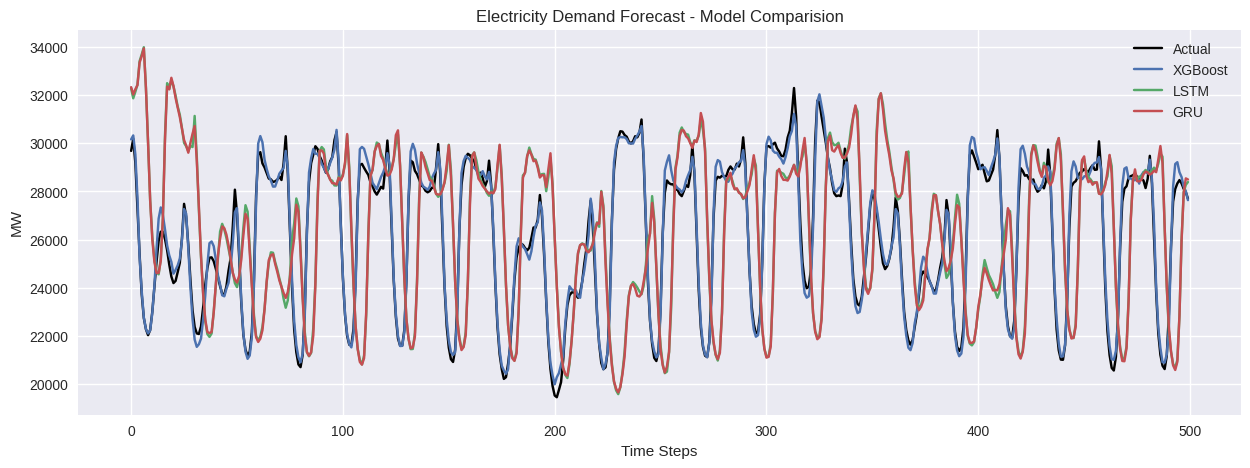

In [ ]:
plt.figure(figsize = (15,5))
plt.plot(y_test.values[:500], label = "Actual", color = "black")
plt.plot(xgb_preds[:500], label = "XGBoost")
plt.plot(lstm_preds[:500], label = "LSTM")
plt.plot(gru_preds[:500], label = "GRU")
plt.legend()
plt.title("Electricity Demand Forecast - Model Comparision")
plt.xlabel("Time Steps")
plt.ylabel("MW")
plt.show()

* The figure compares the actual electricity demand with **predictions generated by XGBoost, LSTM, and GRU** over a selected time window. All models capture the overall demand pattern; however, notable differences are observed in how closely each model follows short-term fluctuations.

* The **XGBoost model** shows a **smoother prediction curve** and tends to **lag during sharp rises and drops**, indicating limited responsiveness to rapid demand changes. In contrast, both **LSTM and GRU** track the actual demand more closely, particularly during **periods of frequent oscillations**.

* Among the LSTM and GRU models, the **GRU predictions align most consistently with the actual series**, especially around peak and trough regions. This visual behavior supports the quantitative results, where GRU achieved lower MAE and RMSE values, reflecting improved accuracy and stability in forecasting hourly electricity demand.

* Overall, the **plot reinforces** the **advantage of sequence-based models over feature-based approaches** for capturing complex temporal dynamics in high-frequency time series data.